# Example usage of sensitivity class and lightcurve functions

In [4]:
#import the standard stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

#this are macros in the same directory
import sensitivity as s
import lightcurve as lc

In [5]:
def cm2inch(value):
    #this one is just for the figure dimensions
    return value/2.54

def powerlaw(p, x):
    m, c = p
    return m*x**(-c)

In [6]:
#initialize the class, no arguments needed
sensi = s.HAWCSensi()

## Example of how to obtain a differential sensitivity datapoint

In [11]:
#Use some variables

#zenith has to be between 0 and 50 deg
#energy between 0.1 and 100 TeV
#time between 1.0 and 100 seconds
zenith = 15. #deg
energy = 0.8 #TeV
time = 50. #seconds

print("sensitivity in erg-1 s-1 cm-2:")
print(sensi.interpolate(zenith,energy,time)) #in dnde (erg-1 cm-2 s-1)

sensitivity in erg-1 s-1 cm-2:
1.1389992829520019e-08


## Example -verification on how we scale the sensitivity to account for integration time

Text(0, 0.5, 'Differential Sensitivity\n 10 deg zenith, 1 TeV\n dnde (erg-1 cm-2 s-1)')

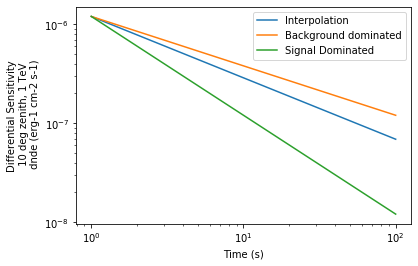

In [15]:
zenith = 0.0 #degrees
energy = 0.5 #TeV
t_test = np.logspace(np.log10(1.0),np.log10(100.),20)
s_test = []

for it in t_test:
    s_test.append(sensi.interpolate(zenith,energy,it))

plt.plot(t_test,s_test, label = "Interpolation")

plt.plot(t_test,sensi.interpolate(zenith,energy,1.0)/np.sqrt(t_test), label = "Background dominated")
plt.plot(t_test,sensi.interpolate(zenith,energy,1.0)/t_test, label = "Signal Dominated")
plt.legend()
plt.loglog()
plt.xlabel("Time (s)")
plt.ylabel("Differential Sensitivity\n 10 deg zenith, 1 TeV\n dnde (erg-1 cm-2 s-1)")

## Example on how to obtain sensitivity vs time for an array of times

This returns an array of values with energy flux sensitivity in units of erg cm-2 s-1 at an energy range (e_min,e_max)

In [14]:
ti = 10**np.arange(-1,3.5,.5)
tf = 10**np.arange(-.5,4,.5)
tc = (tf+ti)/2

print("Calculanting sensitivity vs time for times [s]:")
print(tc)
print(" ")
#arguments are s.sensitivity_vs_time(zenith, e_min, e_max, array_of_times)

zenith = 0.
e_min = 0.3
e_max = 1.0

s_vs_time = sensi.sensitivity_vs_time( zenith , e_min , e_max,tc)
print("The energy flux sensitivity in erg cm-2 s-1 is: ")
print(s_vs_time)

Calculanting sensitivity vs time for times [s]:
[2.08113883e-01 6.58113883e-01 2.08113883e+00 6.58113883e+00
 2.08113883e+01 6.58113883e+01 2.08113883e+02 6.58113883e+02
 2.08113883e+03]
 
The energy flux sensitivity in erg cm-2 s-1 is: 
[2.683161666757079e-06, 1.3120520408252392e-06, 6.416021486893608e-07, 3.1375518537431876e-07, 1.5343562126741725e-07, 7.503631405819868e-08, 3.669666808729186e-08, 1.7946983172023226e-08, 8.77739808376511e-09]


## See this in action for GRB190114C

In [16]:
xrt_grb190114c = lc.read_xrt_lc("./swift_lc/grb190114c.txt",False)
bat_grb190114c = lc.read_bat_lc("./swift_lc/grb190114c.txt",False)

<Figure size 340.157x240.945 with 0 Axes>

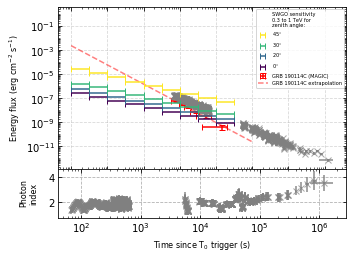

In [20]:
fig = plt.figure( figsize = (cm2inch(12.0),cm2inch(8.5)))

swiftkwargs   = { 'fmt': 'x', 'color': 'gray' , 'linestyle':'', 'alpha':0.7, 'linewidth':2.0 }

ax1, ax2 = lc.plot_xrt(xrt_grb190114c, [], **swiftkwargs)

zenith = [0,20,30,45]
cmap = mpl.cm.get_cmap('viridis')

plotSensiLabel = len(zenith)*[None]
plotSensi = len(zenith)*[None]

for n,(z,c) in enumerate(zip(zenith,[cmap(c) for c in np.linspace(0,1,len(zenith))])):
    ## Important here below 
    plotSensi[n] = ax1.errorbar(tc, 0.1*np.array(sensi.sensitivity_vs_time(z, 0.3,1.0,tc)), 
                 xerr = [tf-tc, tc-ti], capsize = 3, color=c, fmt='none', zorder = 10)
    plotSensiLabel[n] = r"{}$^{{\circ}}$".format(z)

#Magic extrapolation
tiMagic = np.array([62,100,140,210,361.5,800])
tfMagic = np.array([100,140,210,361.5,800,2454])
fluxMagic = [5.64e-8, 3.31e-8, 1.89e-8, 7.54e-9, 3.10e-9, 4.54e-10] 
fluxErrMagic = [.9e-8, .67e-8, .36e-8, 1.6e-9, .7e-9, 2.04e-10] 

alpha = 1.6
tcMagic = ((tiMagic**(1-alpha)-tfMagic**(1-alpha))/(tiMagic-tfMagic-tiMagic*alpha+tfMagic*alpha))**(-1/alpha) #Where to stick you data points

t = np.logspace(-1,4, 100)
flux = fluxMagic[0]*(t/tcMagic[0])**(-alpha)
lcExtra, = ax1.plot(t,flux, linestyle='--', color='red', alpha=0.5, label="GRB 190114C extrapolation")
    
lcMagic = ax1.errorbar(tcMagic, fluxMagic, xerr = [tfMagic-tcMagic, tcMagic-tiMagic] ,yerr=fluxErrMagic, color='red', capsize = 3, fmt='none', label="GRB 190114C (MAGIC)")


#pimp
dummy, = ax1.plot([1],[1],alpha=0)
ax1.legend([dummy]+plotSensi[::-1]+[lcMagic, lcExtra], ["SWGO sensitivity\n0.3 to 1 TeV for\nzenith angle:"]+plotSensiLabel[::-1]+["GRB 190114C (MAGIC)", "GRB 190114C extrapolation"], fontsize=5, loc=1)

#plt.savefig("/home/hin/ednaruiz/img/grb190114c_swgo.pdf")